In [12]:
import pandas as pd

# Load the dataset
data = pd.read_csv('creditcard.csv')

# Basic data exploration
print(data.head())
print(data.info())
print(data.describe())


   Time        V1        V2        V3        V4        V5        V6        V7   
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599  \
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25   
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539  \
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

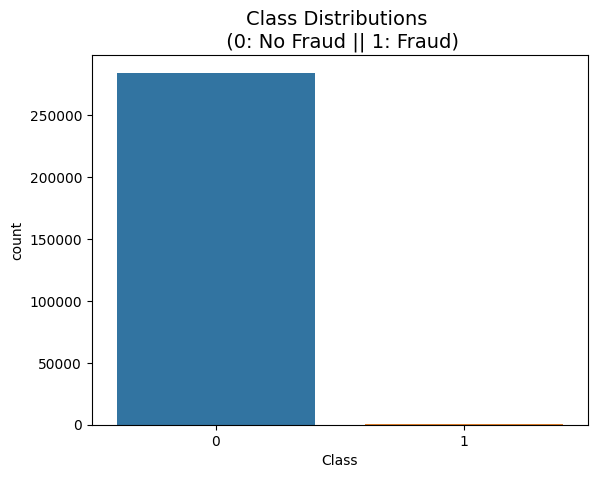

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the class imbalance
sns.countplot(x='Class', data=data)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()


In [14]:
from imblearn.over_sampling import SMOTE

# Define features and target
X = data.drop('Class', axis=1)
y = data['Class']

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



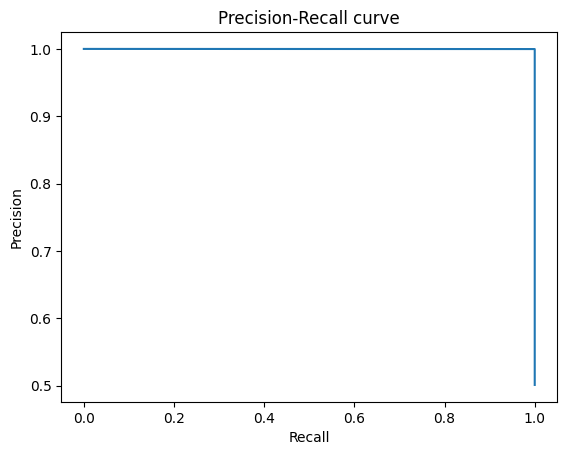

AUPRC: 0.9999034867601383


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Compute and plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

# Compute Area Under the Precision-Recall Curve (AUPRC)
print('AUPRC:', auc(recall, precision))


LogisticRegression AUC: 1.00 (+/- 0.00)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56750
           1       0.99      0.97      0.98     56976

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726

RandomForest AUC: 1.00 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

XGBoost AUC: 1.00 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00  

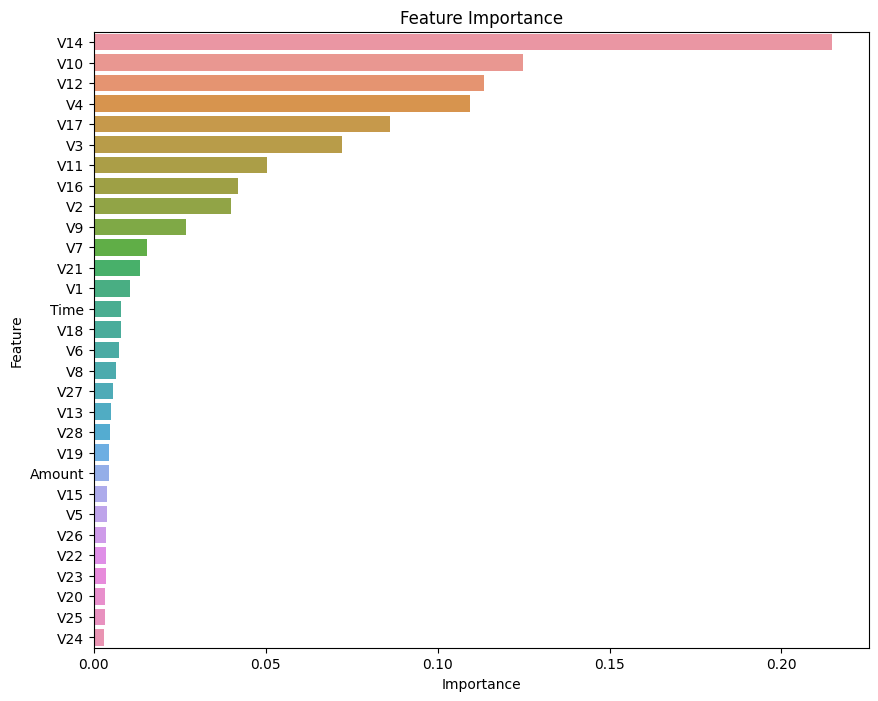

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Feature names in order
feature_names = ["Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12",
                "V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24",
                "V25","V26","V27","V28","Amount"]
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

# Also scale the test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Define models with increased max_iter and a different solver
models = [
    ('LogisticRegression', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=42))
]

# Cross-validation and performance comparison
for name, model in models:
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f'{name} AUC: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})')

    # Fit the model on scaled data and make predictions
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    print(classification_report(y_test, y_pred))

# Train RandomForest for feature importance
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
